# **Intializing and Making needed Functions**

In [2]:
from numpy.random import seed
seed(1)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import itertools

import keras

np.random.seed(123)

def basic_EDA(df):
    size = df.shape
    sum_duplicates = df.duplicated().sum()
    sum_null = df.isnull().sum().sum()
    is_NaN = df. isnull()
    row_has_NaN = is_NaN. any(axis=1)
    rows_with_NaN = df[row_has_NaN]
    count_NaN_rows = rows_with_NaN.shape
    return print("Number of Samples: %d,\nNumber of Features: %d,\nDuplicated Entries: %d,\nNull Entries: %d,\nNumber of Rows with Null Entries: %d %.1f%%" %(size[0],size[1], sum_duplicates, sum_null,count_NaN_rows[0],(count_NaN_rows[0] / df.shape[0])*100))

def summary_table(df):
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']    
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    return summary

def countplot(df, x, x_axis_title,y_axys_title, plot_title):
    plt.figure(figsize=(20,8))
    sns.set(style="ticks", font_scale = 1)
    ax = sns.countplot(data = df,x=x,order = df[x].value_counts().index,palette="Blues_d")
    sns.despine(top=True, right=True, left=True, bottom=False)
    plt.xticks(rotation=0,fontsize = 12)
    ax.set_xlabel(x_axis_title,fontsize = 14,weight = 'bold')
    ax.set_ylabel(y_axys_title,fontsize = 14,weight = 'bold')
    plt.title(plot_title, fontsize = 16,weight = 'bold')  

2024-02-02 05:39:14.757869: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-02 05:39:14.757978: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-02 05:39:15.058233: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **Loaded dataset and preview some sample images**

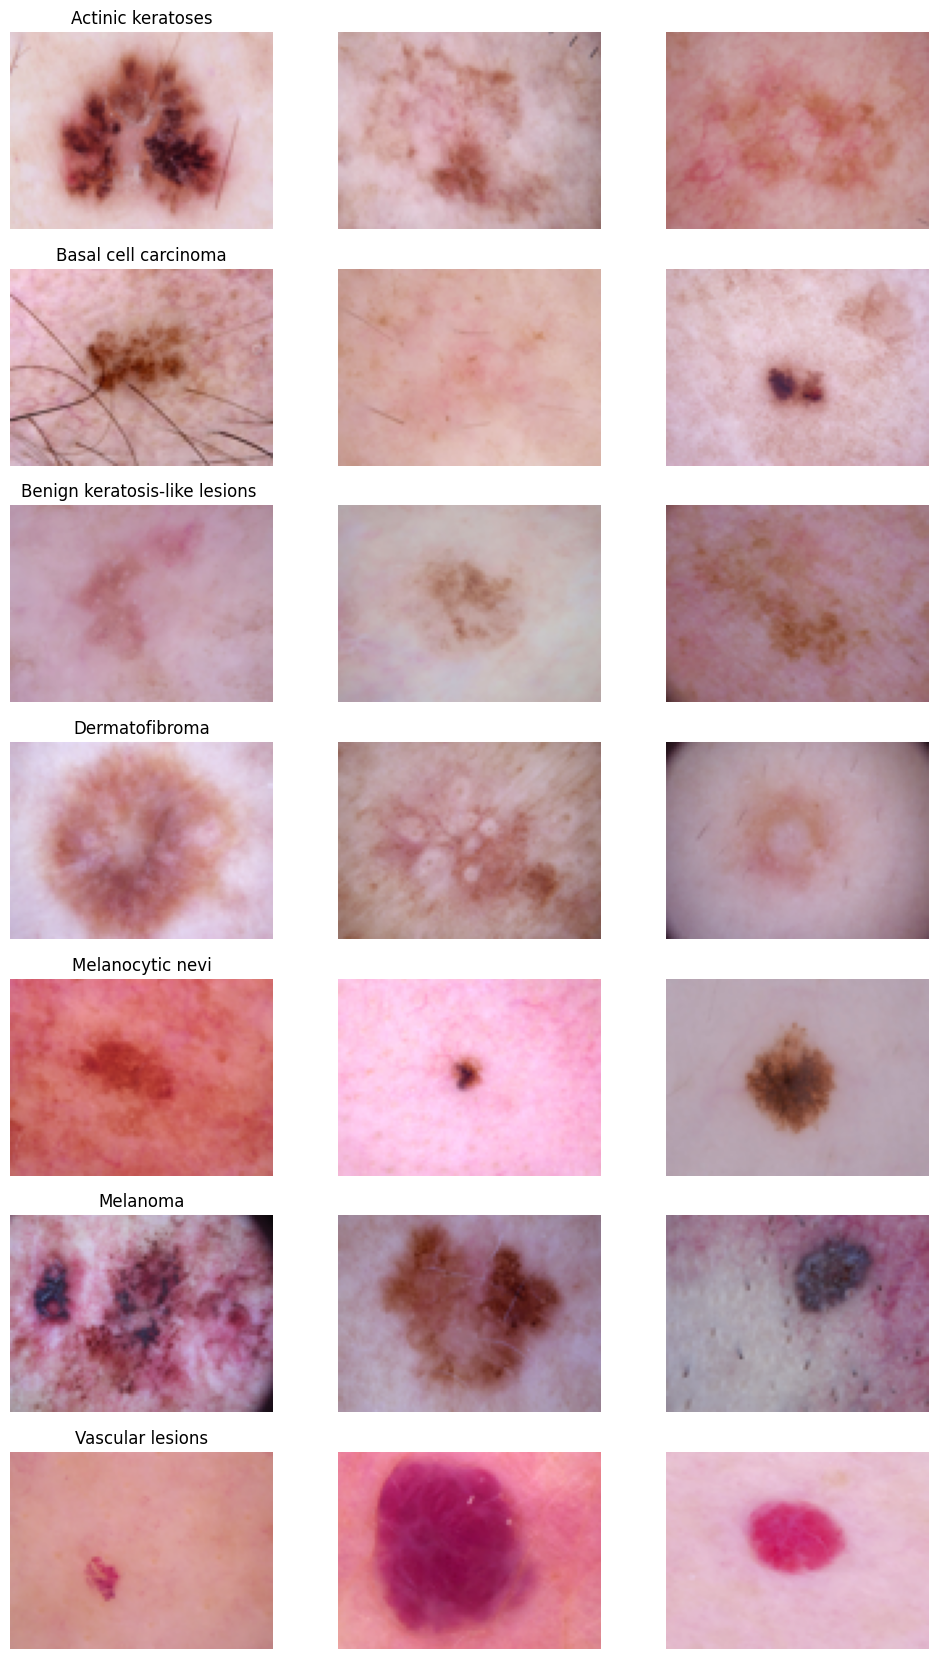

In [3]:
import os
from glob import glob
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

# Base directory for Kaggle input
base_skin_dir_part_1 = '/kaggle/input/finaldataset/HAM10000_images_part_1'
base_skin_dir_part_2 = '/kaggle/input/finaldataset/HAM10000_images_part_2'

# Dictionary for Image Names - Part 1
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(base_skin_dir_part_1, '*.jpg'))}

# Dictionary for Image Names - Part 2
imageid_path_dict1 = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(base_skin_dir_part_2, '*.jpg'))}

# Combine dictionaries
imageid_path_dict.update(imageid_path_dict1)

# Read CSV file
skin_df = pd.read_csv('/kaggle/input/metadata2/meta.csv')

# Create useful columns - Images Path, Lesion Type, and Lesion Categorical Code
skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get)
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

# Sample 500 images
img = skin_df.sample(n=500, replace=False, random_state=1)

# Image Sampling
n_samples = 3

fig, m_axs = plt.subplots(7, n_samples, figsize=(4 * n_samples, 3 * 7))

for n_axs, (type_name, type_rows) in zip(m_axs, img.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(np.asarray(Image.open(c_row['path']).resize((100, 75))))
        c_ax.axis('off')

plt.show()

# **Data Analysis**

/tmp/ipykernel_34/3526343382.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  skin_df['age'].fillna(skin_df['age'].mode(), inplace=True)


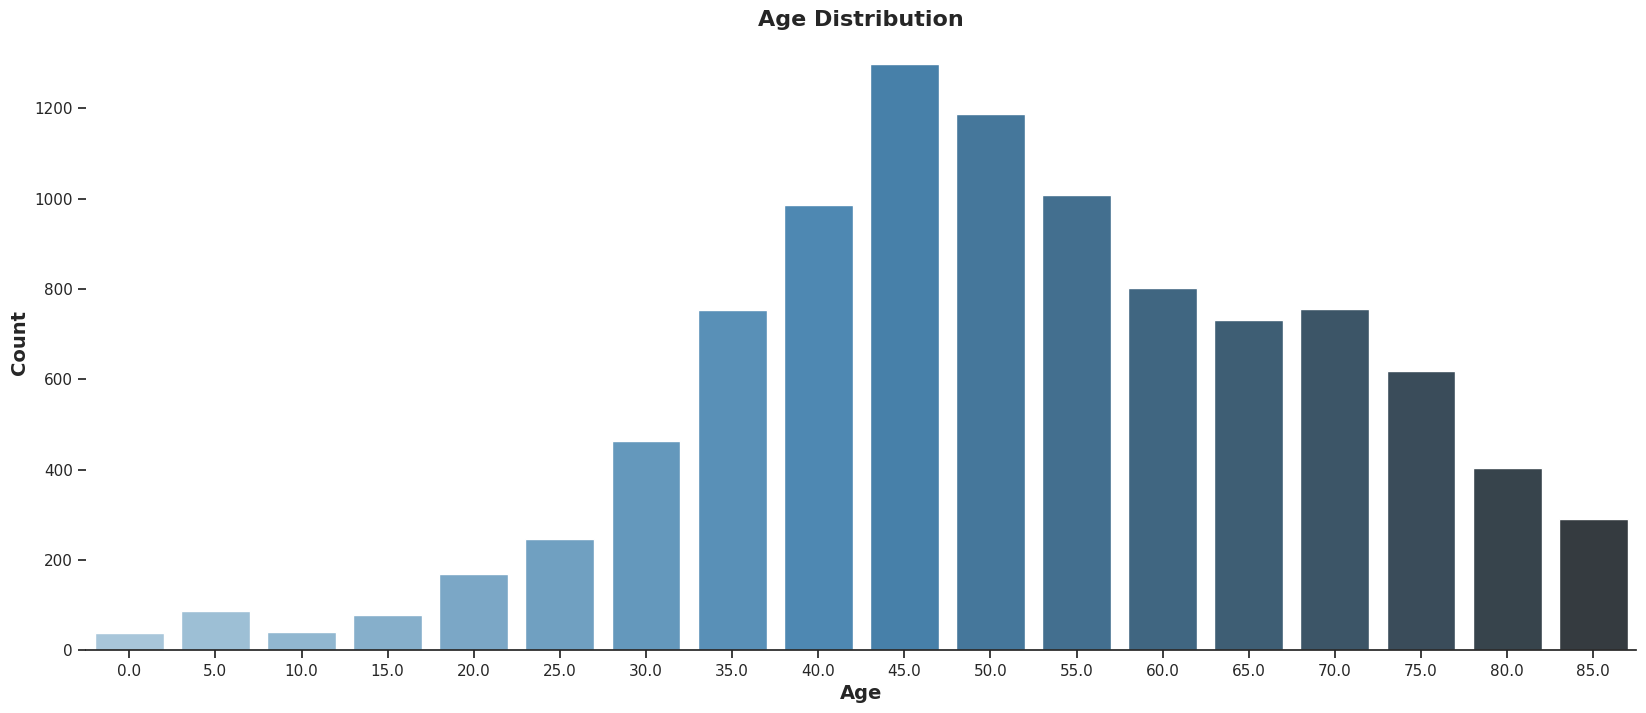

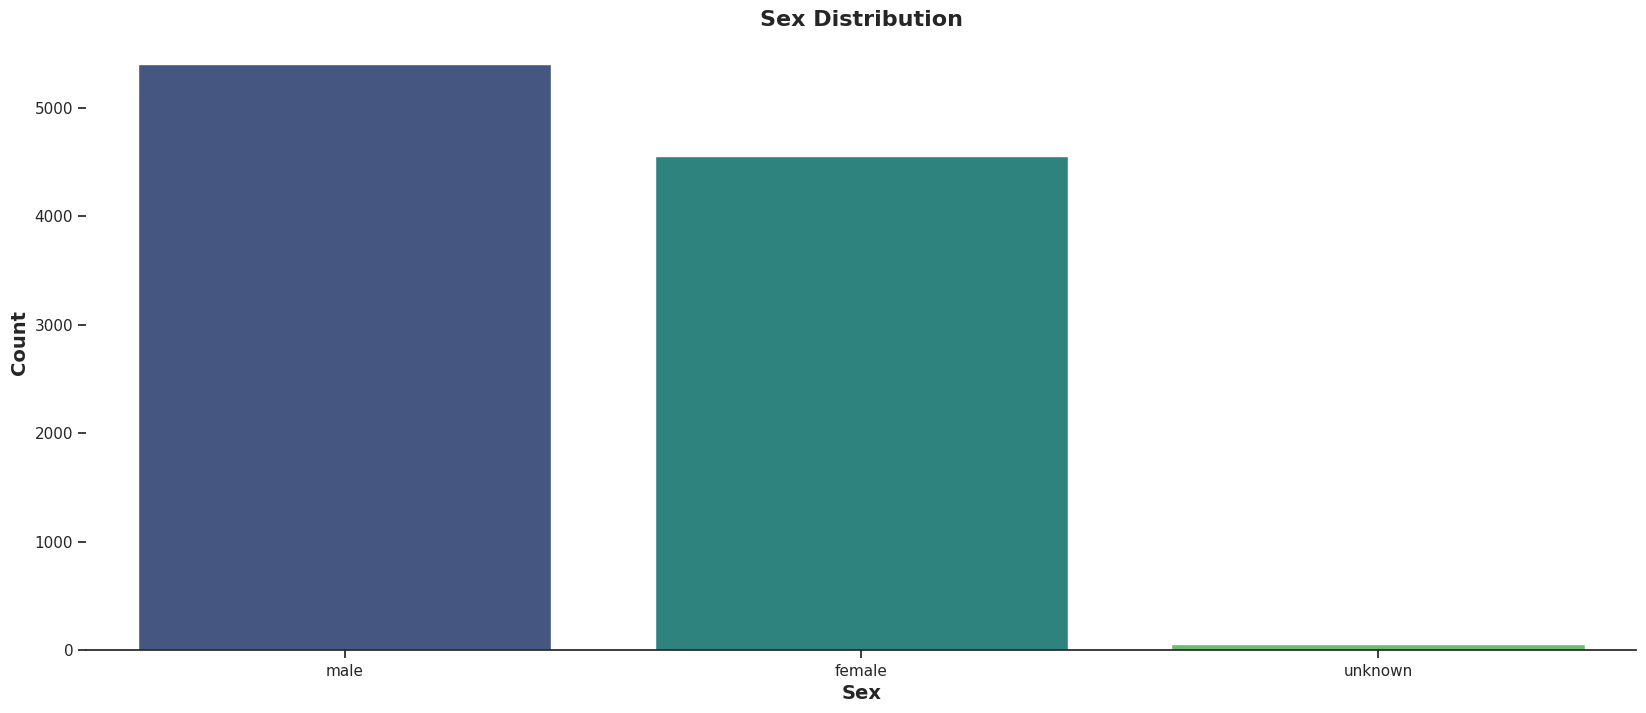

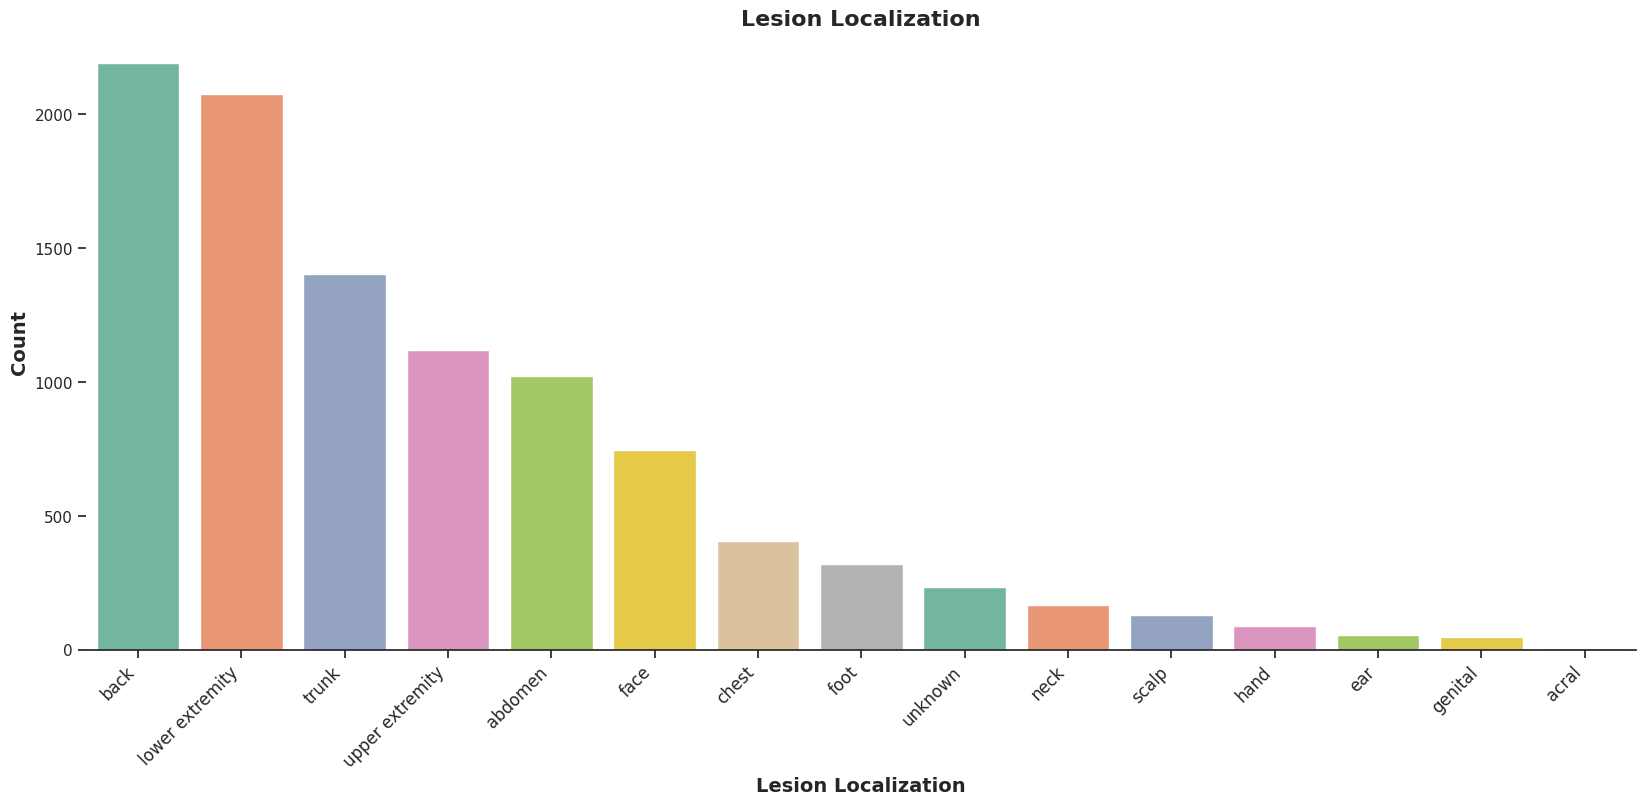

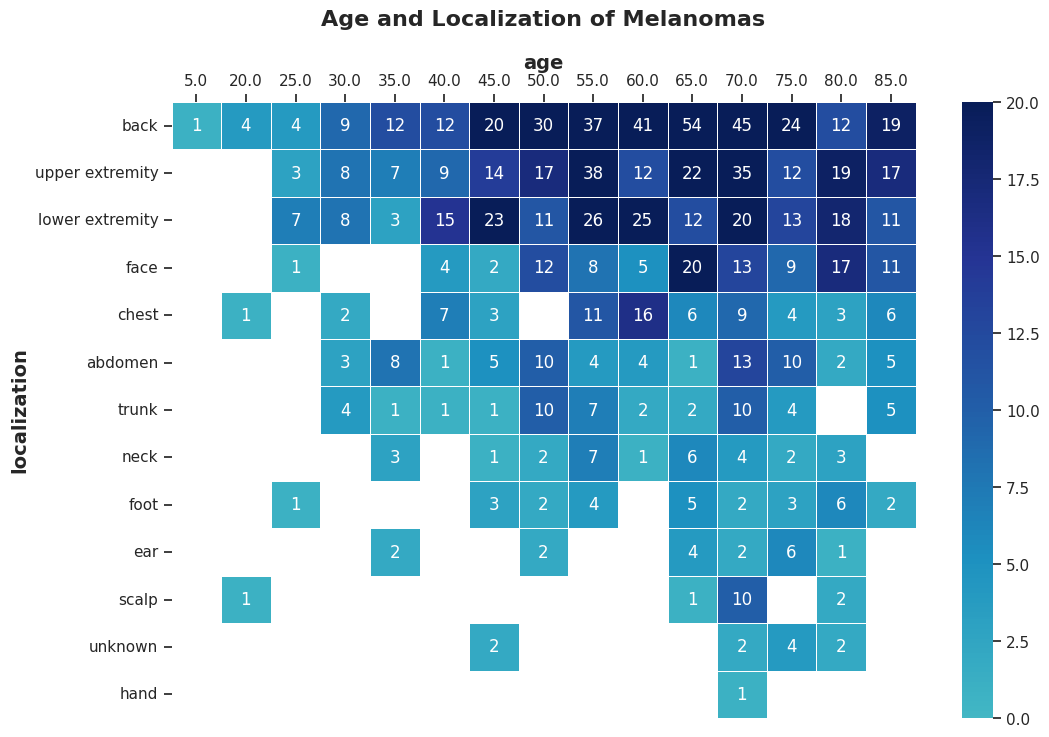

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

skin_df['age'].fillna(skin_df['age'].mode(), inplace=True)

# Age distribution plot
plt.figure(figsize=(20, 8))
sns.set(style="ticks", font_scale=1)
ax_age = sns.countplot(data=skin_df, x='age', palette="Blues_d")
sns.despine(top=True, right=True, left=True, bottom=False)
ax_age.set_xlabel('Age', fontsize=14, weight='bold')
ax_age.set_ylabel('Count', fontsize=14, weight='bold')
ax_age.set_title('Age Distribution', fontsize=16, weight='bold')
plt.savefig('age_distribution.png')
plt.show()
plt.close()

plt.figure(figsize=(20, 8))
sns.set(style="ticks", font_scale=1)
ax_sex = sns.countplot(data=skin_df, x='sex', palette="viridis")
sns.despine(top=True, right=True, left=True, bottom=False)
ax_sex.set_xlabel('Sex', fontsize=14, weight='bold')
ax_sex.set_ylabel('Count', fontsize=14, weight='bold')
ax_sex.set_title('Sex Distribution', fontsize=16, weight='bold')
plt.savefig('sex_distribution.png')
plt.show()
plt.close()

plt.figure(figsize=(20, 8))
sns.set(style="ticks", font_scale=1)
ax_localization = sns.countplot(data=skin_df, x='localization', palette="Set2", order=skin_df['localization'].value_counts().index)
sns.despine(top=True, right=True, left=True, bottom=False)
plt.xticks(rotation=45, fontsize=12, ha='right')
ax_localization.set_xlabel('Lesion Localization', fontsize=14, weight='bold')
ax_localization.set_ylabel('Count', fontsize=14, weight='bold')
ax_localization.set_title('Lesion Localization', fontsize=16, weight='bold')
plt.savefig('54654654646_localization_distribution.png')
plt.show()
plt.close()

skin_mel = skin_df.loc[:,['age','sex','localization','cell_type']]
skin_mel = skin_mel[skin_mel['cell_type'] == 'Melanoma']
skin_local = skin_mel.groupby(['localization']).size().sort_values(ascending=False, inplace=False).reset_index()
skin_local.columns = ['localization', 'count']
sort_by = skin_local['localization']

skin_heat = skin_mel.groupby(['age','localization']).size().reset_index()
skin_heat.columns = ['age', 'localization', 'count']
skin_heat.sort_values('count', ascending=False, inplace=True)

def heatmap(df, index,columns,values,vmax,sort_by,Title):
    df_wide = df.pivot(index=index, columns=columns, values=values)
    df_wide = df_wide.reindex(index=sort_by)
    plt.figure(figsize=(12,8))
    ax = sns.heatmap(df_wide, annot=True, fmt='.0f', yticklabels='auto', cmap=sns.color_palette("YlGnBu", as_cmap=True), center=.2,vmin = 0, vmax = vmax,linewidths=.5)
    ax.xaxis.tick_top() # x axis on top
    ax.xaxis.set_label_position('top')
    ax.set_xlabel(columns,fontsize = 14,weight = 'bold')
    ax.set_ylabel(index,fontsize = 14,weight = 'bold')    
    ax.set_title(Title,fontsize = 16,weight = 'bold',pad=20)
    plt.show()
    
heatmap(skin_heat,'localization', 'age','count', 20,sort_by,'Age and Localization of Melanomas')

# **Data Preprocessing and Augmentation**

In [5]:
from keras.utils import to_categorical
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

features=skin_df.drop(columns=['cell_type_idx'],axis=1)
target=skin_df['cell_type_idx']

# Create First Train and Test sets
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20,random_state=123)

#The normalisation is done using the training set Mean and Std. Deviation as reference
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_train_mean)/x_train_std

# Perform one-hot encoding on the labels
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

#Splitting training into Train and Validatation sets
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1,random_state=123)

#Reshaping the Images into 3 channels (RGB)
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

from keras.preprocessing.image import ImageDataGenerator

input_shape = (75, 100, 3)
num_classes = 7
batch_size = 20

# Data Augmentation
dataaugment = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=90,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=10
)

dataaugment.fit(x_train)
steps_per_epoch=x_train.shape[0] // batch_size

# **Proposed Models**

In [ ]:
#AM1

from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

def build_custom_model(input_shape=(75, 100, 3), num_classes=7):
    model = models.Sequential([
        layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape, padding='same'),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

am1 = build_custom_model()

am1.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])

am1.summary()

checkpoint = ModelCheckpoint('model_custom_1.h5',
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='max',
                             verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              min_lr=1e-6,
                              verbose=1)

history_model_custom_1 = am1.fit(
    dataaugment.flow(x_train, y_train, batch_size=batch_size),
    epochs=100,
    validation_data=(x_validate, y_validate),
    verbose=1,
    steps_per_epoch=x_train.shape[0] // batch_size,
    callbacks=[checkpoint ,reduce_lr]
)

In [ ]:
# AM2

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=1000,
    decay_rate=0.9,
    staircase=True
)
optimizer_am2 = tf.keras.optimizers.Adam(learning_rate=lr_schedule)


am2 = Sequential([
    layers.Conv2D(128, (3, 3), activation='relu', input_shape=(75, 100, 3), padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(1024, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    
    layers.Dense(2048, activation='relu'),
    layers.BatchNormalization(),
    
    layers.Dense(1024, activation='relu'),
    layers.BatchNormalization(),
    
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    
    layers.Dense(7, activation='softmax') 
])

am2.compile(loss='categorical_crossentropy', optimizer=optimizer_am2, metrics=['accuracy'])

am2.summary()

# Model Checkpoint and Reduce Learning Rate on Plateau callbacks
checkpoint = ModelCheckpoint(
    'model_complex_9.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

history_am2 = am2.fit(
    dataaugment.flow(x_train, y_train, batch_size=batch_size),
    epochs=100,
    validation_data=(x_validate, y_validate),
    verbose=1,
    steps_per_epoch=x_train.shape[0] // batch_size,
    callbacks=[checkpoint, reduce_lr]
)

# **Pretrained Models**

In [ ]:
# ResNet50

from tensorflow.keras.applications import ResNet50

base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(75, 100, 3))
model_resnet50_v3 = Sequential([
    base_model_resnet,
    Flatten(),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(7, activation='softmax')  
])
model_resnet50.compile(loss="categorical_crossentropy",
              optimizer=Adam(learning_rate=1e-4),
              metrics=['accuracy'])

checkpoint = ModelCheckpoint('model_resnet50.h5',
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='max',
                             verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              min_lr=1e-6,
                              verbose=1)

history_model_resnet50 = model_resnet50_v3.fit(
    dataaugment.flow(x_train, y_train, batch_size=batch_size),
    epochs=80,
    validation_data=(x_validate, y_validate),
    verbose=1,
    steps_per_epoch=x_train.shape[0] // batch_size,
    callbacks=[checkpoint, reduce_lr]
)

In [ ]:
#VGG16

from tensorflow.keras.applications import VGG16
base_model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(75, 100, 3))
model_vgg16 = Sequential([
    base_model_vgg16,
    Flatten(),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(7, activation='softmax') 
])
model_vgg16.compile(loss="categorical_crossentropy",
              optimizer=Adam(learning_rate=1e-4),
              metrics=['accuracy'])

checkpoint = ModelCheckpoint('model_vgg16.h5',
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='max',
                             verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              min_lr=1e-6,
                              verbose=1)

history_model_vgg16 = model_vgg16.fit(
    dataaugment.flow(x_train, y_train, batch_size=batch_size),
    epochs=80,
    validation_data=(x_validate, y_validate),
    verbose=1,
    steps_per_epoch=x_train.shape[0] // batch_size,
    callbacks=[checkpoint, reduce_lr]
)

# **Load Saved Models**

In [8]:
import tensorflow as tf
model_custom_1 = tf.keras.models.load_model('/kaggle/input/saved-model/custom_files/model_custom_1.h5')
model_custom_9 = tf.keras.models.load_model('/kaggle/input/saved-model/custom_files/model_custom_9.h5')
model_vgg16 = tf.keras.models.load_model('/kaggle/input/saved-model/custom_files/model_vgg16.h5')
model_resnet50 = tf.keras.models.load_model('/kaggle/input/saved-model/custom_files/model_resnet50_v3.h5')

# **Evaluation (AUC)**

63/63 [==============================] - 1s 19ms/step


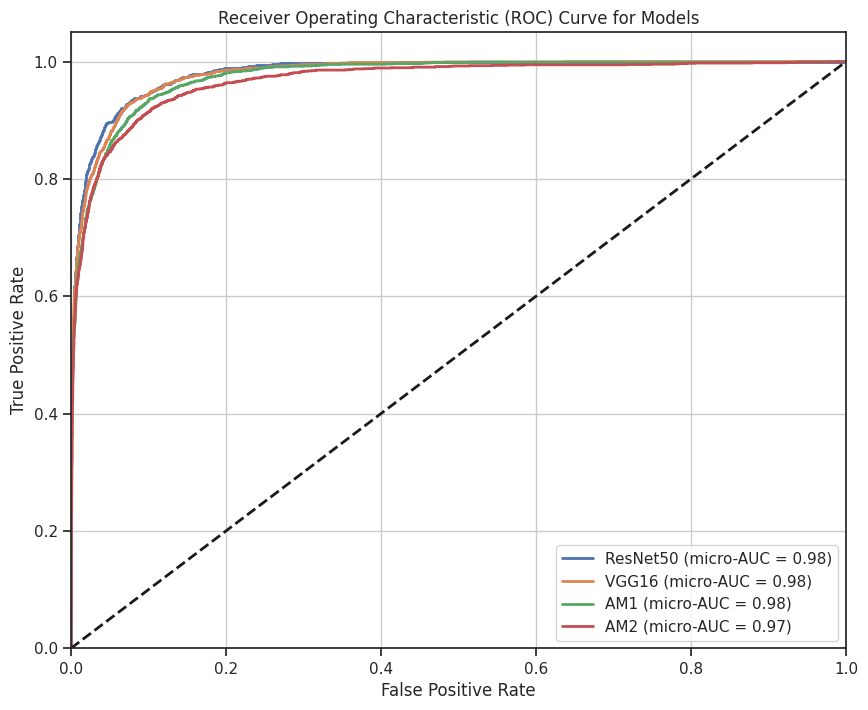

In [12]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import os

def plot_combined_roc_curve(models_dict, x_test, y_test, num_classes, save_dir='/kaggle/working/'):
    plt.figure(figsize=(10, 8))
    
    for model_name, model in models_dict.items():
        predictions = model.predict(x_test)
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        
        for i in range(num_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], predictions[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), predictions.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
        plt.plot(fpr["micro"], tpr["micro"], lw=2, label=f'{model_name} (micro-AUC = {roc_auc["micro"]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2) 
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve for Models')
    plt.legend(loc='lower right')
    plt.grid(True)
    
    # Save the plot
    save_path = os.path.join(save_dir, 'combined_roc_curve.png')
    plt.savefig(save_path)
    plt.show()
    plt.close()

models_new3 = {
    'ResNet50': model_resnet50,
    'VGG16': model_vgg16,
    'AM1': model_custom_1,
    'AM2': model_custom_9,  
}
num_classes = 7
plot_combined_roc_curve(models_new3, x_test, y_test, num_classes, save_dir='/kaggle/working/')


# **Classification Report**

In [14]:
from termcolor import colored
def classification(model_name):
    predictions = model_name.predict(x_test)
    from sklearn.metrics import classification_report
    y_true = y_test.argmax(axis=1) 
    y_pred = predictions.argmax(axis=1)

    report = classification_report(y_true, y_pred)
    print(f"{report}\n")
    
for model_name, model_instance in models_new3.items():
    modelname = colored(model_name, attrs=['bold'])
    print(f'Classification record for {modelname} --> ')
    classification(model_instance)

Classification record for ResNet50 --> 
63/63 [==============================] - 1s 15ms/step
              precision    recall  f1-score   support

           0       0.64      0.58      0.61        64
           1       0.71      0.71      0.71       100
           2       0.69      0.69      0.69       225
           3       0.65      0.71      0.68        24
           4       0.90      0.96      0.93      1320
           5       0.69      0.47      0.56       240
           6       0.92      0.73      0.81        30

    accuracy                           0.84      2003
   macro avg       0.74      0.69      0.71      2003
weighted avg       0.83      0.84      0.83      2003


Classification record for VGG16 --> 
63/63 [==============================] - 2s 25ms/step
              precision    recall  f1-score   support

           0       0.40      0.66      0.50        64
           1       0.63      0.57      0.60       100
           2       0.65      0.63      0.64       225
